File for all figures in the paper.

In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import multiprocess as mp
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from coin import COIN
from environments import CustomMountainCarEnv
from rl import QLearningAgent, COINQLearningAgent

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Figure 1: Contextualisation and Clustering

## Plot effect of contextual policies on a training environment

In [2]:
# Set scale factors for testing
sf = np.concatenate([
    0.0*np.ones((5000, )), 
    1.0*np.ones((5000, )),
    1.5*np.ones((5000, )),
    0.5*np.ones((5000, )),
    0.5*np.ones((5000, )),
    1.5*np.ones((5000, )),
    0.0*np.ones((5000, )),
    1.0*np.ones((5000, )),
    1.0*np.ones((5000, ))
    ])

train_basic = False # Set to True to train the models, otherwise load saved values
train_coin = False
train_oracle = False
train_optimal = False

MAX_CORES = 17
N_REPS = 100 # Number of repetitions of each model for averaging


### Basic no-context model.

In [3]:
def run_single_rep(rep_id, sf):
    """
    Runs one repetition of training across all amplitudes in sf.
    Returns the list of rewards.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import QLearningAgent
    # Create a fresh agent and environment inside each process

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = QLearningAgent(
        env=env,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        min_epsilon=0.01
    )

    rewards_for_this_rep = []
    for i, amplitude in enumerate(sf):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, max_steps_per_episode=200)
        rewards_for_this_rep.append(training_reward)

        # Reset the environment epsilon at a change in amplitude
        if i > 0 and amplitude != sf[i - 1]:
            agent.epsilon = 1.0

        if (i + 1) % 500 == 0:
            print(f"Repetition {rep_id}, Amplitude {amplitude}: Training reward = {training_reward}")

    return rewards_for_this_rep

REWARDS_PATH = "models/fig1a_rewards_basic.npy"
if train_basic:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_basic = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_basic)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_basic = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

Loaded rewards from 'models/fig1a_rewards_basic.npy'.


### COIN Model

In [4]:
COIN_PATH = "models/fig1a_coin_model_out.npy"

coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

if train_coin:
    # COIN model takes a long time to run - we simplify calculation here by assuming that 
    # the scale factor stays the same every 50 episodes.
    coin_model.perturbations = sf[::50]

    output = coin_model.simulate_coin()

    known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
    p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 
    p_contexts = np.repeat(p_contexts, repeats=50, axis=0)

    # Ensure COIN probabilities are of the right form
    # Novel context - should never have a NaN definition
    p_temp = p_contexts.copy()
    p_temp[np.isnan(p_temp)] = 0.0
    p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1)
    
    # Save coin model output
    np.save(COIN_PATH, p_contexts)
else:
    # Load the saved results from the training
    if os.path.exists(COIN_PATH):
        p_contexts = np.load(COIN_PATH)
        known_c_resp = p_contexts[:,:-1]
        novel_c_resp = p_contexts[:,-1]
        print(f"Loaded probabilities from '{COIN_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved probabilities found at '{COIN_PATH}'.")

Loaded probabilities from 'models/fig1a_coin_model_out.npy'.


In [5]:
def run_single_rep(rep_id, sf, p_context):
    """
    Runs one repetition of training across all amplitudes in sf.
    Returns the list of rewards.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import COINQLearningAgent
    # Create a fresh agent and environment inside each process

    C = p_context.shape[1]-1

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = COINQLearningAgent(
        env=env,
        max_contexts=C,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999
    )

    rewards_for_this_rep = []
    for i, amplitude in enumerate(sf):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, p_context=p_context[i,:], max_steps_per_episode=200)
        rewards_for_this_rep.append(training_reward)

        if (i + 1) % 500 == 0:
            print(f"Repetition {rep_id}, Amplitude {amplitude}: Training reward = {training_reward}")

    return rewards_for_this_rep

REWARDS_PATH = "models/fig1a_rewards_coin.npy"
if train_coin:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf, p_contexts) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_coin = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_coin)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_coin = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

Loaded rewards from 'models/fig1a_rewards_coin.npy'.


### Oracle (True Context Known)

In [6]:
REWARDS_PATH = "models/fig1a_rewards_oracle.npy"

# We use the COIN Q-learning framework, although with perfect context knowledge
p_contexts_oracle = np.zeros_like(p_contexts)
p_contexts_oracle[sf==0.0, 0] = 1.0
p_contexts_oracle[sf==0.5, 1] = 1.0
p_contexts_oracle[sf==1.0, 2] = 1.0
p_contexts_oracle[sf==1.5, 3] = 1.0
if train_oracle:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf, p_contexts_oracle) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_oracle = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_oracle)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_oracle = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

Loaded rewards from 'models/fig1a_rewards_oracle.npy'.


### Optimal Model

In [7]:
if train_optimal:
    # Optimal model will train on the amplitude values for 30000 episodes
    envs = [CustomMountainCarEnv(amplitude=amp, render_mode="none") for amp in [0.0, 0.5, 1.0, 1.5]]
    agents = [QLearningAgent(
        env=envs[i],
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9999,
        min_epsilon=0.01
    ) for i in range(4)]

    rewards_optimal = []

    for i in range(4):
        # Create the MountainCar environment with the true amplitude
        env = envs[i]

        # Train the agent in the current context
        agent = agents[i]
        _, training_rewards = agent.train(
            env=env,
            max_steps_per_episode=200,
            n_episodes=30000,
        )

        rewards_optimal.append(np.max(training_rewards))

        # Print the average training reward every 500 episodes
        print(f"Agent {i+1}, Average Training reward: {np.mean(training_rewards[-1000:])}")

    for i in range(4):
        # Create the MountainCar environment with the true amplitude
        env = envs[i]

        # Evaluate the agent in the current context
        agent = agents[i]
        evaluation_reward = agent.evaluate(
            env=env,
            max_steps_per_episode=200,
            n_episodes=1,
        )

        # If evaluation_reward[0] > rewards_optimal[i], substitute:
        if evaluation_reward[0] > rewards_optimal[i]:
            rewards_optimal[i] = evaluation_reward[0]

        # Save results
        np.save("models/fig1a_rewards_optimal.npy", rewards_optimal)
        with open("models/fig1a_rewards_optimal.pkl", "wb") as f:
            pickle.dump(agents, f)
else:
    # Load the saved results from the training
    if os.path.exists("models/fig1a_rewards_optimal.npy"):
        rewards_optimal = np.load("models/fig1a_rewards_optimal.npy")
        print(f"Loaded rewards from 'models/fig1a_rewards_optimal.npy'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at 'models/fig1a_rewards_optimal.npy'.")
    if os.path.exists("models/fig1a_rewards_optimal.pkl"):
        with open("models/fig1a_rewards_optimal.pkl", "rb") as f:
            agents = pickle.load(f)
        print(f"Loaded agents from 'models/fig1a_rewards_optimal.pkl'.")
    else:
        raise FileNotFoundError(f"No saved agents found at 'models/fig1a_rewards_optimal.pkl'.")

Loaded rewards from 'models/fig1a_rewards_optimal.npy'.
Loaded agents from 'models/fig1a_rewards_optimal.pkl'.


### Figure 1a Plotting

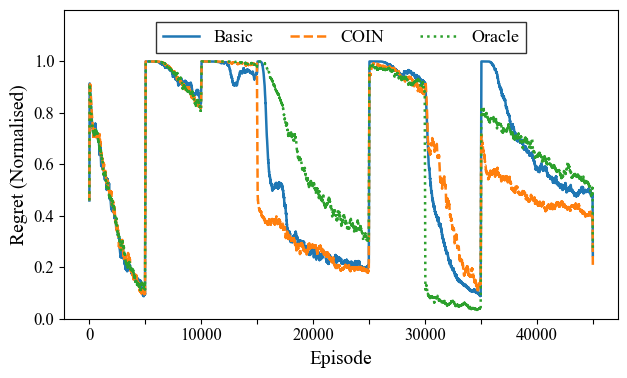

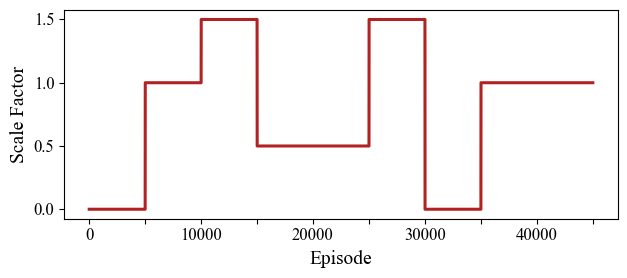

In [9]:
# Calculate regret for each different contextual model - specific to our data (not generalizable), here only for plotting
def calculate_regret(rewards, optimal_rewards, sf_assignment):
    """
    Calculate the regret for our scale factor data. Scale the regret to allow for better comparison.
    """
    regret = np.zeros_like(rewards)
    for i in range(len(optimal_rewards)):
        # Add the optimal reward for the corresponding amplitude
        regret[sf_assignment == i] = (-rewards[sf_assignment==i] + optimal_rewards[i])/(200+optimal_rewards[i])  
    return regret

sf_assignment = np.zeros_like(sf, dtype=int)
for i, amplitude in enumerate([0.0, 0.5, 1.0, 1.5]):
    sf_assignment[sf == amplitude] = i
regret_basic = calculate_regret(rewards_basic, rewards_optimal, sf_assignment)
regret_coin = calculate_regret(rewards_coin, rewards_optimal, sf_assignment)
regret_oracle = calculate_regret(rewards_oracle, rewards_optimal, sf_assignment)

# Plot smooth versions of the regrets
regret_basic_s = np.convolve(regret_basic,np.ones(50,)/50, mode='same')
regret_coin_s = np.convolve(regret_coin,np.ones(50,)/50, mode='same')
regret_oracle_s = np.convolve(regret_oracle,np.ones(50,)/50, mode='same')

# Tableau color palette
tableau_colors = plt.get_cmap("tab10").colors
color_basic = tableau_colors[0]   # blue
color_coin = tableau_colors[1]    # orange
color_oracle = tableau_colors[2]  # green

# Font setup
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Plot
plt.figure(figsize=(6.5, 4))
plt.plot(regret_basic_s, label='Basic', color=color_basic, linewidth=1.8)
plt.plot(regret_coin_s, label='COIN', color=color_coin, linewidth=1.8, linestyle='--')
plt.plot(regret_oracle_s, label='Oracle', color=color_oracle, linewidth=1.8, linestyle=':')

plt.ylim(-0.0, 1.2)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=12)
xticks = np.arange(0, len(regret_basic_s)+1, 5000)
plt.xticks(xticks)

# Labels and legend
plt.xlabel('Episode')
plt.ylabel('Regret (Normalised)')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=3,
    frameon=True,
    fancybox=False,
    facecolor='white',
    edgecolor='black'
)

# Tidy up
plt.tight_layout()
# Hide every other label
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 10000 != 0:
        label.set_visible(False)
plt.savefig('figures/fig1a_regret.svg', dpi=300, bbox_inches='tight')  # Save as PDF for high quality
plt.show()

# Parameter variation plot
plt.figure(figsize=(6.5, 3))
plt.plot(sf, color='firebrick', linewidth=2.2, label='Scale Factor (sf)')

plt.xlabel('Episode')
plt.ylabel('Scale Factor')

plt.yticks(np.array([0.0, 1.0, 1.5, 0.5]), fontsize=12)
xticks = np.arange(0, len(regret_basic_s)+1, 5000)
plt.xticks(xticks)

plt.tight_layout()
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 10000 != 0:
        label.set_visible(False)
plt.savefig('figures/fig1a_parameter.svg', dpi=300, bbox_inches='tight')
plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(sf)

# plt.figure(figsize=(10,6))
# plt.plot(p_contexts[:,:-1])

# plt.figure(figsize=(10,6))
# plt.plot(p_contexts_oracle[:,:-1])


## Plot different clustering models
Set up data

In [ ]:
# Data to cluster
data = np.concatenate([
    0.0*np.ones((100,)),
    1.0*np.ones((100,)),
    -1.0*np.ones((100,)),
    np.linspace(-1.0,1.0,100),
    0.5*np.ones((100,)),
    0.0*np.ones((100,)),
])

# Number of clusters (does not apply to COIN)
K = 4

### K-Means

In [ ]:
def _kmeans_pp_init(x: np.ndarray, K: int, rng: np.random.Generator):
    """k‑means++ initialisation for 1‑D data (returns K starting centroids)."""
    centroids = np.empty(K, dtype=x.dtype)
    centroids[0] = rng.choice(x)

    # Squared distances to the closest chosen centroid
    d2 = (x - centroids[0]) ** 2

    for k in range(1, K):
        probs = d2 / d2.sum()
        centroids[k] = rng.choice(x, p=probs)
        d2 = np.minimum(d2, (x - centroids[k]) ** 2)

    return centroids


def kmeans_1d(
    P,
    K: int,
    max_iter: int = 100,
    tol: float = 1e-4,
    seed: int | None = None,
    verbose: bool = False,
):
    """
    Clusters 1‑D data P into K groups.

    Parameters
    ----------
    P : array‑like shape (N,)
        The data points (floats or ints).
    K : int
        Number of clusters.
    max_iter : int
        Maximum number of Expectation–Maximisation iterations.
    tol : float
        Convergence threshold on centroid shift.
    seed : int or None
        RNG seed for reproducibility.
    verbose : bool
        If True, prints loss and centroid shift each iteration.

    Returns
    -------
    labels : ndarray shape (N,)
        Cluster index (0..K‑1) for every point in P.
    centroids : ndarray shape (K,)
        Final centroid positions.
    """
    # --- prepare data & RNG ---
    x = np.asarray(P, dtype=float).ravel()
    N = x.size
    rng = np.random.default_rng(seed)

    # --- initial centroids ---
    centroids = _kmeans_pp_init(x, K, rng)

    for it in range(1, max_iter + 1):
        # ----- E‑step: assign each point to nearest centroid -----
        distances = np.abs(x[:, None] - centroids[None, :])  # (N, K)
        labels = distances.argmin(axis=1)                   # (N,)

        # ----- M‑step: recompute centroids (mean of assigned points) -----
        new_centroids = np.empty_like(centroids)
        for k in range(K):
            points_k = x[labels == k]
            # handle empty cluster ⇒ re‑initialise to random point
            new_centroids[k] = points_k.mean() if points_k.size else rng.choice(x)

        # ----- check convergence -----
        shift = np.abs(new_centroids - centroids).max()
        if verbose:
            inertia = ((x - new_centroids[labels]) ** 2).sum()
            print(f"iter {it:03d}  inertia={inertia:,.3f}  shift={shift:.5f}")
        if shift < tol:
            break
        centroids = new_centroids

    return labels, centroids

# Run k-means clustering
labels_kmeans, centroids_kmeans = kmeans_1d(data, K=K, verbose=False)


In [ ]:
# Plot data with clusters
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(data.size),data, c=labels_kmeans, cmap='viridis', s=100)

# Label each context



### GMMs

In [ ]:
import numpy as np
from numpy.random import default_rng
from math import log, pi


# ---------- utilities ---------------------------------------------------------
def _log_gaussian(x, mu, var):
    """log 𝒩(x | μ, σ²) — vectorised over x."""
    return -0.5 * (np.log(2 * pi * var) + (x - mu) ** 2 / var)


def _kmeans_pp_init(x, K, rng):
    """1‑D k‑means++ initial means (returns sorted for convenience)."""
    means = np.empty(K, dtype=x.dtype)
    means[0] = rng.choice(x)
    d2 = (x - means[0]) ** 2
    for k in range(1, K):
        probs = d2 / d2.sum()
        means[k] = rng.choice(x, p=probs)
        d2 = np.minimum(d2, (x - means[k]) ** 2)
    return np.sort(means)


# ---------- deterministic‑annealing EM ---------------------------------------
def gmm_1d_da(x, K, anneal_schedule, max_iter=60, tol=1e-5, rng=None, verbose=0):
    """
    One run of EM with an annealing schedule β₁…β_M (0<β<=1).
    Returns (logL, labels, π, μ, var).
    """
    if rng is None:
        rng = default_rng()
    N = x.size

    # initial parameters -------------------------------------------------------
    mu = _kmeans_pp_init(x, K, rng)
    var = np.full(K, x.var() + 1e-6)
    pi = np.full(K, 1.0 / K)

    def e_step(beta):
        # responsibilities γᵢₖ ∝ (πₖ 𝒩)ᵝ
        log_prob = beta * (_log_gaussian(x[:, None], mu, var) + np.log(pi))
        log_tot = log_prob.max(axis=1, keepdims=True) + np.log(
            np.exp(log_prob - log_prob.max(axis=1, keepdims=True)).sum(axis=1, keepdims=True)
        )
        resp = np.exp(log_prob - log_tot)
        return resp, log_tot.sum() / beta          # true log‑likelihood (β cancels)

    # annealing loop -----------------------------------------------------------
    prev_ll = -np.inf
    for beta in anneal_schedule:
        for _ in range(max_iter):
            resp, ll = e_step(beta)
            Nk = resp.sum(axis=0) + 1e-10
            pi = Nk / N
            mu = (resp.T @ x) / Nk
            diff2 = (x[:, None] - mu) ** 2
            var = (resp * diff2).sum(axis=0) / Nk
            var = np.clip(var, 1e-6, None)

            if ll - prev_ll < tol:
                break
            prev_ll = ll
        if verbose:
            print(f"β={beta:.2f}  iter≤{max_iter}  logL={ll:.4f}")

    labels = resp.argmax(axis=1)
    return ll, labels, pi, mu, var


# ---------- multi‑start wrapper ----------------------------------------------
def gmm_1d_robust(
    P,
    K: int,
    restarts: int = 10,
    anneal_schedule: list[float] | None = None,
    max_iter: int = 60,
    tol: float = 1e-5,
    seed: int | None = None,
    verbose: bool = False,
):
    """
    Robust GMM clustering.

    Parameters
    ----------
    P                : 1‑D data (array‑like)
    K                : number of components
    restarts         : how many independent runs to try
    anneal_schedule  : list of β values. e.g. [0.2,0.4,0.6,0.8,1.0].
                       None → plain EM (β=1).
    max_iter, tol    : inner EM settings
    seed             : RNG seed
    verbose          : print progress

    Returns
    -------
    best_labels, best_pi, best_mu, best_var
    """
    x = np.asarray(P, dtype=float).ravel()
    rng_master = default_rng(seed)

    if anneal_schedule is None:
        anneal_schedule = [1.0]                     # plain EM

    best_ll = -np.inf
    best_res = None

    for r in range(restarts):
        rng = default_rng(rng_master.integers(1 << 32))
        ll, labels, pi, mu, var = gmm_1d_da(
            x,
            K,
            anneal_schedule,
            max_iter=max_iter,
            tol=tol,
            rng=rng,
            verbose=(verbose and restarts > 1),
        )
        if verbose and restarts > 1:
            print(f"restart {r+1}/{restarts}  final logL={ll:.4f}")

        if ll > best_ll:
            best_ll = ll
            best_res = (labels, pi, mu, var)

    if verbose and restarts > 1:
        print(f"best logL={best_ll:.4f}")

    return best_res  # unpack as needed


# -------------------------- demo ---------------------------------------------
rng = default_rng(23)
labels_gmm, pi_gmm, mu_gmm, var_gmm  = gmm_1d_robust(
    data,
    K=K,
    max_iter=2000,
    restarts=10,
    anneal_schedule=[1.0],
    verbose=True,
)


In [ ]:
# Plot probabilities - find gaussian mixture likelihood for each point
likel = np.vstack([pi_gmm[k] * np.exp(_log_gaussian(data, mu_gmm[k], var_gmm[k])) for k in range(K)])
likel = likel / np.sum(likel, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(likel.T)

plt.figure(figsize=(10, 6))
plt.plot(data.T)




### Mutual Information

In [ ]:
class InfoMax1DClusterer(nn.Module):
    """Small MLP that acts as a discriminator q_theta(y|x)."""
    def __init__(self, K: int, hidden: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, K)
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=1)      # q_theta(y|x)


def mutual_information_loss(q_batch: torch.Tensor, eps: float = 1e-10):
    """
    -I(X;Y) Estimator (negative for optimisation).
    q_batch  : (B, K) distributions q_theta(y|x) for a minibatch.
    """
    # Pseudo-counts of clusters in the batch
    p_y = q_batch.mean(dim=0)                    # (K,)
    H_y = -(p_y * (p_y + eps).log()).sum()

    H_y_given_x = -(q_batch * (q_batch + eps).log()).sum(dim=1).mean()

    return -(H_y - H_y_given_x)


def fit_infomax(P, K=3, epochs=500, batch_size=128, lr=1e-3, seed=0,
                verbose=True):
    """
    Train the discriminator and develop clustering indices for each point.
    P          : array‑like unidimensional (n_samples,)
    K          : cluster count
    epochs     : training iterations
    batch_size : minibatch size
    lr         : learning rate Adam
    seed       : reproducibility
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # ----- Prepare data -----
    x = np.asarray(P, dtype=np.float32).reshape(-1, 1)
    dataset = TensorDataset(torch.tensor(x))
    loader = DataLoader(dataset, batch_size=min(batch_size, len(x)),
                        shuffle=True, drop_last=False)

    # ----- Model and optimiser -----
    model = InfoMax1DClusterer(K)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # ----- Training -----
    for epoch in range(1, epochs + 1):
        for (batch,) in loader:
            q = model(batch)
            loss = mutual_information_loss(q)
            opt.zero_grad()
            loss.backward()
            opt.step()
        if verbose and epoch % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch:>4}/{epochs},  –I(X;Y) ≈ {loss.item():.4f}")

    # ----- Assign final tags -----
    with torch.no_grad():
        q_all = model(torch.tensor(x))
        labels = torch.argmax(q_all, dim=1).cpu().numpy()

    return labels, model


labels, model = fit_infomax(data, K=K, epochs=300)
print("Assigned classes (first 20):", labels[:20])


In [ ]:
# Obtain probabilities for each class
x = np.asarray(data, dtype=np.float32).reshape(-1, 1)
q_all = model(torch.Tensor(x))
q_all = q_all.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
plt.plot(q_all)

### COIN

In [ ]:
# Use COIN to classify the data - here we use the retention model

coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
) # use default parameters for now

coin_model.perturbations = data

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

In [ ]:
# Plot probabilities for each class
plt.figure(figsize=(10, 6))
plt.plot(known_c_resp)